# Part 0: Setup model and download pretrained weights

In [ ]:
#@title Setup model

import os
os.chdir('/content')
!wget https://github.com/arash-mham/visual-computing-II/raw/main/assignments/A4-StyleGAN/stylegan2.zip
!unzip stylegan2.zip

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

--2024-03-05 01:18:50--  https://github.com/arash-mham/visual-computing-II/raw/main/assignments/A4-StyleGAN/stylegan2.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/arash-mham/visual-computing-II/main/assignments/A4-StyleGAN/stylegan2.zip [following]
--2024-03-05 01:18:51--  https://raw.githubusercontent.com/arash-mham/visual-computing-II/main/assignments/A4-StyleGAN/stylegan2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15121 (15K) [application/zip]
Saving to: ‘stylegan2.zip’

stylegan2.zip       100%[===================>]  14.77K  --.-KB/s    in 0s      

2024-03-05 01:18:51 (4

In [ ]:
#@title import modules

import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

%pip install -q ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torchvision.utils import make_grid


#this part might take a while
from stylegan2.model import Generator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00


In [ ]:
#download checkpoint
#ignore warning of deprecated pydrive


#@title Setup checkpoint downloader
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True

CODE_DIR = ''
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive
        current_directory = os.getcwd()
        self.save_dir = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
        os.makedirs(self.save_dir, exist_ok=True)
        print(self.save_dir)
        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)
id = '1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT'
file_name = 'stylegan2-ffhq-config-f.pt'

downloader.download_file(id, file_name)

/pretrained_models


# Part 1: Image generation with StyleGAN2

In [ ]:
class Generator_Wrapper:
  def __init__(self):
    #initialize model
    self.model = Generator(1024, 512, 8).to('cuda')
    #load pretrained weights to the generator
    self.init_weights()
    #Generator generates images of resolution 1024x1024. To downsample the images, we apply average pooling to bring it to the resolution 256x256
    self.face_pool = torch.nn.AdaptiveAvgPool2d((256, 256))
  def init_weights(self):
    self.model.load_state_dict(torch.load('../pretrained_models/stylegan2-ffhq-config-f.pt')['g_ema'])

  def generate_image(self, input = None, input_is_latent = False, num_images = 1):
    #input: if None you should generate the z latent code. z should be of size (num_images, 512)
    #input_is_latent: if input is not None, it means that we are providing the latent code to the function. If the latent code is in the Z space input_is_latent should be False. If the latent code is in the W space the input_is_latent should be True
    #num_images: number of images that we want to generate

    #returns: output images with size (num_images, 3, 256, 256)
    #returns: latent codes in the W space with size (num_images, 18, 512)
    if input is None:
      #TODO: generate random z codes
      input = torch.randn(num_images, 512, device='cuda')

    #TODO: use the Generator to generate images and output latents
    out, latents = self.model([input], input_is_latent=input_is_latent, return_latents=True)
    #TODO: downsample the images with the average pooling module
    out = self.face_pool(out)
    return out, latents

  def tensor2image(self, out):
    #TODO: given tensor of size (B, 3, 256, 256) in the range(-1, 1) return a PIL Image with size (256, 256 * B, 3)
    out = (out.detach().cpu() + 1) / 2  # Normalize to [0, 1]
    images = make_grid(out, nrow=1)
    np_image = images.numpy().transpose(1, 2, 0)
    np_image = np.clip(np_image, 0, 1)
    return Image.fromarray((np_image * 255).astype('uint8'))

In [ ]:
G = Generator_Wrapper()
images, latents = G.generate_image(num_images = 4)

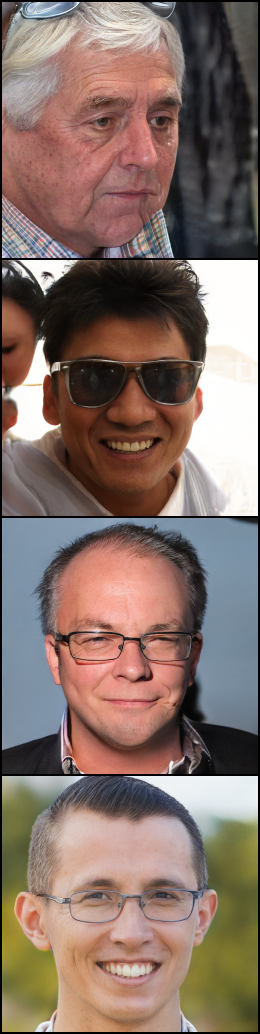

In [ ]:
G.tensor2image(images)

# Part 2: Latent interpolation

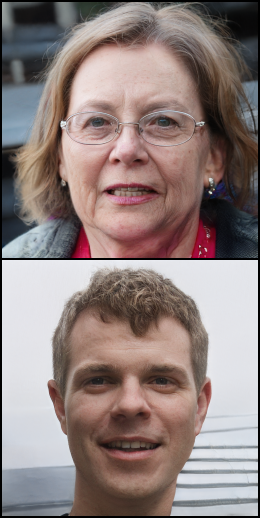

In [ ]:
#TODO: generate two images and visualize

images, latents = G.generate_image(num_images=2)
G.tensor2image(images)

In [ ]:
#interpolate two latents
def interpolate_latents(interpolate_scale):
  #TODO: interpolate between two latents generated above. interpolate_scale (r) is the interpolation coefficient
  # Select the first two latent codes for interpolation
  l1, l2 = latents
  # Perform linear interpolation between l1 and l2
  new_latent = new_latent = interpolate_scale * l1 + (1 - interpolate_scale) * l2
  # Since generate_image expects a batch dimension, unsqueeze new_latent to simulate a batch of 1
  new_latent = new_latent.unsqueeze(0)
  image_new, latent_new = G.generate_image(input=new_latent, input_is_latent=True, num_images=1)
  image_new = G.tensor2image(image_new)
  return image_new

In [ ]:
#make slider and visualize
interact(interpolate_latents, interpolate_scale=widgets.FloatSlider(0.5, min=0, max=1., step=0.05))

interactive(children=(FloatSlider(value=0.5, description='interpolate_scale', max=1.0, step=0.05), Output()), …

<function __main__.interpolate_latents(interpolate_scale)>

#Part 3: Latent Mixing

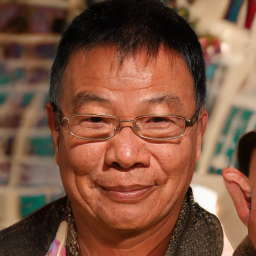

In [ ]:
#TODO: make a base image with latents and visualize
base_image, base_latents = G.generate_image(num_images=1)
G.tensor2image(base_image)

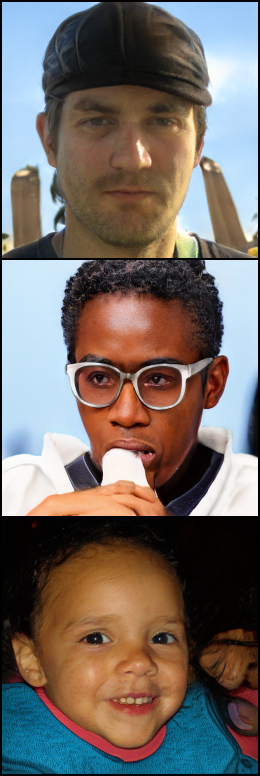

In [ ]:
#TODO: make 3 new faces. They will be edited using base latent
editing_images, editing_latents = G.generate_image(num_images=3)
G.tensor2image(editing_images)

In [ ]:
def mix_latents(mixing_point):
  #TODO: mix latents. the first mixing_point blocks should get the latent from base_latent and the rest come from editing_latents
  # Create a new tensor to hold the mixed latents
  mixed_latents = torch.empty_like(editing_latents)
  # Mix latents based on the mixing_point
  mixed_latents[:, :mixing_point, :] = base_latents[:, :mixing_point, :]
  mixed_latents[:, mixing_point:, :] = editing_latents[:, mixing_point:, :]
  edited_images, _ = G.generate_image(input=mixed_latents, input_is_latent=True, num_images=editing_latents.shape[0])
  return G.tensor2image(edited_images)


In [ ]:
interact(mix_latents, mixing_point=widgets.IntSlider(0, min=0, max=18, step=1))

interactive(children=(IntSlider(value=0, description='mixing_point', max=18), Output()), _dom_classes=('widget…

<function __main__.mix_latents(mixing_point)>

# Part 4: StyleGAN inversion

In [ ]:
#@title download image alignment library and landmarks
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2


--2024-03-05 01:34:44--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  15.0MB/s    in 4.3s    

2024-03-05 01:34:49 (14.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
#@title download image to invert
!wget https://github.com/arash-mham/visual-computing-II/blob/main/assignments/A4-StyleGAN/image.jpg?raw=true -O image.jpg

--2024-03-05 01:34:58--  https://github.com/arash-mham/visual-computing-II/blob/main/assignments/A4-StyleGAN/image.jpg?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/arash-mham/visual-computing-II/raw/main/assignments/A4-StyleGAN/image.jpg [following]
--2024-03-05 01:34:58--  https://github.com/arash-mham/visual-computing-II/raw/main/assignments/A4-StyleGAN/image.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/arash-mham/visual-computing-II/main/assignments/A4-StyleGAN/image.jpg [following]
--2024-03-05 01:34:58--  https://raw.githubusercontent.com/arash-mham/visual-computing-II/main/assignments/A4-StyleGAN/image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.

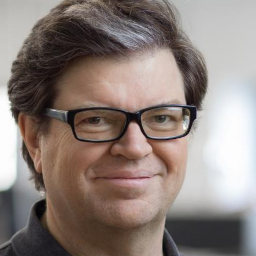

In [ ]:
#run alignment on image
from stylegan2.alignment import align_face
import dlib

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
aligned_image = align_face('image.jpg', predictor=predictor)
aligned_image

In [ ]:
#load latent average for good initialization
average_latent = torch.load('../pretrained_models/stylegan2-ffhq-config-f.pt')['latent_avg']

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
import numpy as np

In [ ]:
#TODO: follow the assignment document to complete this part

#Only using MSE loss on the input image and output of the generator, optimize the latent code. Does the result resemble the input image?

def optimize_latent_code_w_space(aligned_image, G, average_latent, num_iterations=1000, lr=0.01):
    target_img_tensor = to_tensor(aligned_image).unsqueeze(0).to('cuda')

    average_latent = average_latent.to('cuda')

    # Initialize a single w vector in W space for optimization
    latent_code = average_latent.unsqueeze(0).clone().requires_grad_(True).to('cuda')

    optimizer = torch.optim.Adam([latent_code], lr=lr)

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        # Generate an image from the current latent code in W space
        # Ensuring to not repeat the latent code across layers since we are now working in W space
        generated_img, _ = G.generate_image(input=latent_code, input_is_latent=True, num_images=1)

        # Calculate MSE loss
        loss = F.mse_loss(generated_img, target_img_tensor)

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item()}")

    final_img_tensor = generated_img.detach().cpu().squeeze(0)
    final_img = to_pil_image(final_img_tensor)

    return latent_code.detach(), final_img

latent_code_optimized, final_img = optimize_latent_code_w_space(aligned_image, G, average_latent, num_iterations=1000, lr=0.01)
final_img.save("optimized_image_w.jpg")

Iteration 0: Loss = 0.4800029695034027
Iteration 100: Loss = 0.02551964297890663
Iteration 200: Loss = 0.018497591838240623
Iteration 300: Loss = 0.014930675737559795
Iteration 400: Loss = 0.01281747967004776
Iteration 500: Loss = 0.011404844932258129
Iteration 600: Loss = 0.010551689192652702
Iteration 700: Loss = 0.009698628447949886
Iteration 800: Loss = 0.008851349353790283
Iteration 900: Loss = 0.0083394106477499


In [ ]:
#W+ space optimization

def optimize_latent_code_wp_space(aligned_image, G, average_latent, num_iterations=1000, lr=0.01):
    target_img_tensor = to_tensor(aligned_image).unsqueeze(0).to('cuda')

    average_latent = average_latent.to('cuda')

    # Initialize the latent code in W+ space to be optimized
    # Here, each of the 18 latent vectors can be optimized independently
    latent_code = average_latent.unsqueeze(0).repeat(1, 18, 1).clone().requires_grad_(True).to('cuda')
    optimizer = torch.optim.Adam([latent_code], lr=lr)

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        # Generate an image from the current latent code
        generated_img, _ = G.generate_image(input=latent_code, input_is_latent=True)

        # Ensure the generated image is in the correct format and on the same device as the target image
        generated_img = generated_img.to('cuda')

        # Calculate MSE loss
        loss = F.mse_loss(generated_img, target_img_tensor)

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item()}")

    # Convert the optimized latent code and the final generated image for visualization
    final_img_tensor = generated_img.detach().cpu().squeeze(0)
    final_img = to_pil_image(final_img_tensor)

    return latent_code.detach(), final_img


latent_code_optimized, final_img = optimize_latent_code_wp_space(aligned_image, G, average_latent, num_iterations=1000, lr=0.01)
final_img.save("optimized_image_wp.jpg")


Iteration 0: Loss = 0.47907066345214844
Iteration 100: Loss = 0.015227735042572021
Iteration 200: Loss = 0.00971120223402977
Iteration 300: Loss = 0.007593471556901932
Iteration 400: Loss = 0.00629351194947958
Iteration 500: Loss = 0.005607606377452612
Iteration 600: Loss = 0.004949259106069803
Iteration 700: Loss = 0.004448008257895708
Iteration 800: Loss = 0.004110821522772312
Iteration 900: Loss = 0.003730581607669592


In [ ]:
!pip install lpips
import lpips
# Initialize the LPIPS model; using the AlexNet version as an example
lpips_model = lpips.LPIPS(net='alex').to('cuda')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 63.5MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
def optimize_latent_code_wp_lpips(aligned_image, G, average_latent, num_iterations=1000, lr=0.01, mse_weight=0.5, lpips_weight=0.5):
    target_img_tensor = to_tensor(aligned_image).unsqueeze(0).to('cuda')

    average_latent = average_latent.to('cuda')

    latent_code = average_latent.unsqueeze(0).repeat(1, 18, 1).clone().requires_grad_(True).to('cuda')
    optimizer = torch.optim.Adam([latent_code], lr=lr)

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        generated_img, _ = G.generate_image(input=latent_code, input_is_latent=True)
        generated_img = generated_img.to('cuda')

        # Calculate MSE loss
        mse_loss = F.mse_loss(generated_img, target_img_tensor)

        # Calculate LPIPS loss
        lpips_loss = lpips_model(generated_img, target_img_tensor)

        # Combine the losses
        total_loss = mse_weight * mse_loss + lpips_weight * lpips_loss

        # Backpropagate the combined loss
        total_loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Total Loss = {total_loss.item()}, MSE Loss = {mse_loss.item()}, LPIPS Loss = {lpips_loss.item()}")

    final_img_tensor = generated_img.detach().cpu().squeeze(0)
    final_img = to_pil_image(final_img_tensor)

    return latent_code.detach(), final_img

# Run the optimization with both MSE and LPIPS losses
latent_code_optimized, final_img_optimized = optimize_latent_code_wp_lpips(aligned_image, G, average_latent, num_iterations=1000, lr=0.01, mse_weight=0.5, lpips_weight=0.5)
final_img_optimized.save("optimized_image_wp_lpips.jpg")


Iteration 0: Total Loss = 0.530366063117981, MSE Loss = 0.48266005516052246, LPIPS Loss = 0.5780721306800842
Iteration 100: Total Loss = 0.09786196798086166, MSE Loss = 0.02146082930266857, LPIPS Loss = 0.1742631047964096
Iteration 200: Total Loss = 0.05910932272672653, MSE Loss = 0.011218669824302197, LPIPS Loss = 0.10699997842311859
Iteration 300: Total Loss = 0.04548691213130951, MSE Loss = 0.009437073022127151, LPIPS Loss = 0.08153675496578217
Iteration 400: Total Loss = 0.03934305161237717, MSE Loss = 0.008965672925114632, LPIPS Loss = 0.06972043216228485
Iteration 500: Total Loss = 0.03442787006497383, MSE Loss = 0.007495235186070204, LPIPS Loss = 0.06136050447821617
Iteration 600: Total Loss = 0.029735155403614044, MSE Loss = 0.007017158903181553, LPIPS Loss = 0.05245315283536911
Iteration 700: Total Loss = 0.026831476017832756, MSE Loss = 0.006360221654176712, LPIPS Loss = 0.0473027303814888
Iteration 800: Total Loss = 0.024691034108400345, MSE Loss = 0.006071371957659721, LPIP

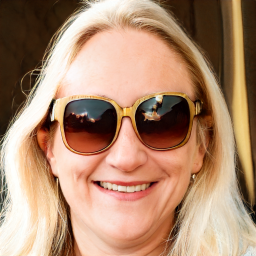

In [ ]:
#BONUS perform latent interpolation and latent mixing on the result of the inversion to edit the image. Include these results in your report

base_image, base_latents = G.generate_image(num_images=1)
G.tensor2image(base_image)

In [ ]:
# Modify the interpolate_latents to return the interpolated latent code
def interpolate_latents(interpolate_scale, latents):
    l1, l2 = latents[0], latents[1]
    new_latent = interpolate_scale * l1 + (1 - interpolate_scale) * l2
    return new_latent.unsqueeze(0)  # Add batch dimension

# Adjust mix_latents to accept an interpolated latent and a mixing point, then generate and return an image
def mix_latents(interpolated_latent, mixing_point, base_latent, editing_latent):
    # Ensure both base_latent and editing_latent are expanded to W+ space if not already
    if base_latent.dim() == 2:  # Assuming [1, 512] shape, needs to be [1, 18, 512]
        base_latent = base_latent.repeat(1, 18, 1)
    if editing_latent.dim() == 2:  # Same assumption and adjustment for editing_latent
        editing_latent = editing_latent.repeat(1, 18, 1)

    # Perform the mixing based on the mixing point
    mixed_latents = base_latent.clone()
    mixed_latents[:, mixing_point:, :] = editing_latent[:, mixing_point:, :]

    # Generate and return the image from the mixed latents
    edited_images, _ = G.generate_image(input=interpolated_latent, input_is_latent=True)
    return G.tensor2image(edited_images)


def update_image(interpolate_scale, mixing_point):
    # Ensure latents are in the correct shape for W+ space
    base_latents_expanded = base_latents.repeat(1, 18, 1) if base_latents.dim() == 2 else base_latents
    latent_code_optimized_expanded = latent_code_optimized.repeat(1, 18, 1) if latent_code_optimized.dim() == 2 else latent_code_optimized

    # Interpolate between the expanded base and optimized latents
    interpolated_latent = interpolate_latents(interpolate_scale, (base_latents_expanded, latent_code_optimized_expanded))

    # Ensure the interpolated latent maintains the correct shape
    if interpolated_latent.dim() == 3 and interpolated_latent.size(1) != 18:
        # This is a safeguard and should not happen if the above conditions are met
        raise ValueError("Interpolated latent does not have expected dimensions for W+ space")

    # Mix and generate the image from the interpolated latent
    output_image = mix_latents(interpolated_latent.squeeze(0), mixing_point, base_latents_expanded, latent_code_optimized_expanded)
    return output_image

In [ ]:
# Setup interactive widgets
interact(update_image,
     interpolate_scale=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Interpolate:'),
     mixing_point=widgets.IntSlider(value=8, min=0, max=18, step=1, description='Mixing Point:'))

interactive(children=(FloatSlider(value=0.5, description='Interpolate:', max=1.0, step=0.01), IntSlider(value=…

<function __main__.update_image(interpolate_scale, mixing_point)>